In [1]:
from os import chdir
chdir('/Users/lananhnguyen/Desktop/thesis/thesis_code')
import main.packages.mine_generic as mine_g
import main.packages.mine_specific as mine_s

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge


In [2]:
hicp_all_path = 'data/preprocessed/hicp_yoy.csv'
hicp_class_path = 'data/HICP_COICOP10s.xlsx'
model = 'ridge'
date_range = pd.date_range(start=mine_g.train_test_split_date + pd.DateOffset(months=1), end=mine_g.max_X_date, freq='M')


# 3. Shrinkage method:
## 3.1. Food:


In [3]:
category = 'Food'
cat_short = 'food'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'

save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly,
                             fillna=False)
cat_df.dropna(axis=1, inplace=True)
food_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Food group:  180


/var/folders/74/zq2msw1x2fj9j2zyq8njktnc0000gn/T/ipykernel_20063/3449463087.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.dropna(axis=1, inplace=True)


In [4]:
cat_df.shape

(312, 147)

In [8]:
h = 1
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(1838, 1840, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)



Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 1839.3999999999987}


In [9]:

N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_g.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)

food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast


Horizon: 1
------------------------


In [14]:
h = 2
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(2513, 2520, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)



Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 2515.299999999998}


In [15]:

N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_g.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast


Horizon: 2
------------------------


In [20]:
h = 3
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(2613, 2616, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)


Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 2613.999999999999}


In [21]:


N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_g.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast


Horizon: 3
------------------------


In [22]:
food_yoy_real = pd.read_csv("data/preprocessed/food_yoy_infl.csv", parse_dates=True, index_col='date')
food_yoy_real_test = food_yoy_real[(food_yoy_real.index > mine_g.train_test_split_date) & (food_yoy_real.index <= mine_g.max_X_date)]
food_compare = pd.concat([food_cat_prediction, food_yoy_real_test], axis = 1)

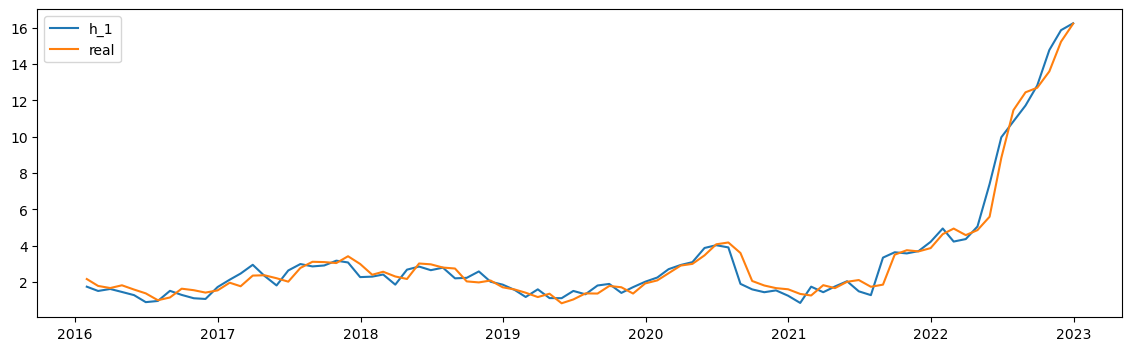

In [23]:
plt.figure(figsize=(14, 4))

plt.plot(food_compare.iloc[:, 0], label = "h_1")
plt.plot(food_compare.iloc[:, 1], label = "real")
plt.legend()
plt.show()

In [24]:
mean_absolute_error(food_compare.loc[:, 'yoy_rate'], food_compare.loc[:, 'ridge_food_h_1'])

0.5157987794521764

In [25]:
np.sqrt(mean_squared_error(food_compare.loc[:, 'yoy_rate'], food_compare.loc[:, 'ridge_food_h_1']))

0.6996719220076493

In [26]:
mine_g.save_forecast(forecast_result_df=food_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)

---

## 3.2. Energy:


In [27]:
cat_short = 'energy'
category = 'Energy'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly,
                             fillna=False)
cat_df.dropna(axis=1, inplace=True)
energy_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Energy group:  14


/var/folders/74/zq2msw1x2fj9j2zyq8njktnc0000gn/T/ipykernel_20063/284154866.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.dropna(axis=1, inplace=True)


In [29]:
h = 1
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(18, 22, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)


Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 18.80000000000001}


In [30]:

N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_g.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
energy_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast


Horizon: 1
------------------------


In [32]:
h = 2
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(46, 50, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)



Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 46.90000000000001}


In [33]:

N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_g.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
energy_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast


Horizon: 2
------------------------


In [35]:
h = 3
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(70, 90, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)


Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 76.89999999999961}


In [36]:

N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_g.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
energy_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast

mine_g.save_forecast(forecast_result_df=energy_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)

Horizon: 3
------------------------


In [37]:
yoy_real = pd.read_csv(f"data/preprocessed/{cat_short}_yoy_infl.csv", parse_dates=True, index_col='date')
yoy_real_test = yoy_real[(yoy_real.index > mine_g.train_test_split_date) & (yoy_real.index <= mine_g.max_X_date)]
df_compare = pd.concat([energy_cat_prediction, yoy_real_test], axis = 1)

print(mean_absolute_error(df_compare.loc[:, 'yoy_rate'], df_compare.loc[:, f'ridge_{cat_short}_h_1']))
print(np.sqrt(mean_squared_error(df_compare.loc[:, 'yoy_rate'], df_compare.loc[:, f'ridge_{cat_short}_h_1'])))

2.5363253570153446
3.8619908121461557


## 3.3. NEIG:

In [38]:
cat_short = 'neig'
category = 'Non-energy industrial goods (NEIG)'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly,
                             fillna=False)
cat_df.dropna(axis=1, inplace=True)
neig_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Non-energy industrial goods (NEIG) group:  302


/var/folders/74/zq2msw1x2fj9j2zyq8njktnc0000gn/T/ipykernel_20063/2898556519.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.dropna(axis=1, inplace=True)


In [41]:
h = 1
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(1810, 1840, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)

Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 1817.2999999999934}


In [42]:
N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_g.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
neig_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast


Horizon: 1
------------------------


In [48]:
h = 2
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(50, 60, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)

Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 50.80000000000001}


In [49]:
N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_g.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
neig_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast

Horizon: 2
------------------------


In [53]:
h = 3
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(660, 670, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)

Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 669.1000000000021}


In [54]:
N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_g.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
neig_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast

# save forecast:
mine_g.save_forecast(forecast_result_df=neig_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)

Horizon: 3
------------------------


In [55]:
yoy_real = pd.read_csv(f"data/preprocessed/{cat_short}_yoy_infl.csv", parse_dates=True, index_col='date')
yoy_real_test = yoy_real[(yoy_real.index > mine_g.train_test_split_date) & (yoy_real.index <= mine_g.max_X_date)]
df_compare = pd.concat([neig_cat_prediction, yoy_real_test], axis = 1)

print(mean_absolute_error(df_compare.loc[:, 'yoy_rate'], df_compare.loc[:, f'ridge_{cat_short}_h_1']))
print(np.sqrt(mean_squared_error(df_compare.loc[:, 'yoy_rate'], df_compare.loc[:, f'ridge_{cat_short}_h_1'])))

0.3819780685834718
0.5790691275096749


## 3.4. Services:

In [56]:
cat_short = 'services'
category = 'Services'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly,
                             fillna=False)
cat_df.dropna(axis=1, inplace=True)
services_cat_prediction = pd.DataFrame(index=date_range)

Number of items in Services group:  148


/var/folders/74/zq2msw1x2fj9j2zyq8njktnc0000gn/T/ipykernel_20063/2534085112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.dropna(axis=1, inplace=True)


In [61]:
h = 1
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(1040, 1050, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)

Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 1047.799999999993}


In [62]:
N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_g.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
services_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast

Horizon: 1
------------------------


In [65]:
h = 2
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(640, 670, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)

Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 650.1000000000023}


In [66]:
N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_g.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
services_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast

Horizon: 2
------------------------


In [68]:
h = 3
X_cat_train, X_cat_test, y_cat_train, y_cat_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = h)

best_param = mine_s.tuning_gridsearchcv(reg= Ridge(),
                                grid_space= np.arange(480, 482, 0.1),
                                X_train= X_cat_train.copy(),
                                y_train= y_cat_train.copy(),
                                test_size=24)
print(best_param)

Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
{'regression__alpha': 481.10000000000025}


In [69]:
N, T = len(X_cat_train), len(X_cat_test)
forecast = mine_g.generate_forecast(X=cat_df, y=HICP_cat, N=N, T=T, h=h, hyperparam=best_param['regression__alpha'], model=Ridge, verbose = 0)
services_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = forecast


# save forecast:
mine_g.save_forecast(forecast_result_df=services_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path, category=cat_short)

Horizon: 3
------------------------


In [70]:
yoy_real = pd.read_csv(f"data/preprocessed/{cat_short}_yoy_infl.csv", parse_dates=True, index_col='date')
yoy_real_test = yoy_real[(yoy_real.index > mine_g.train_test_split_date) & (yoy_real.index <= mine_g.max_X_date)]
df_compare = pd.concat([services_cat_prediction, yoy_real_test], axis = 1)

print(mean_absolute_error(df_compare.loc[:, 'yoy_rate'], df_compare.loc[:, f'ridge_{cat_short}_h_1']))
print(np.sqrt(mean_squared_error(df_compare.loc[:, 'yoy_rate'], df_compare.loc[:, f'ridge_{cat_short}_h_1'])))

0.5062275468997752
0.6534727624780515
